In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

from lis import *

In [2]:
qnps_answers = np.random.choice(
    a=[i for i in range(11)],
    p=[(1/11) for i in range(11)],
    size=885)



nps = pd.Series(qnps_answers)
promoters = nps.apply(lambda x: 1 if x in [9, 10] else 0)
passives = nps.apply(lambda x: 1 if x in [7, 8] else 0)
detractors = nps.apply(lambda x: 1 if x < 7 else 0)
print('promoters.describe()')
print(promoters.describe())
print()
print('passives.describe()')
print(passives.describe())
print()
print(detractors.describe())
print('detractors.describe()')



promoters.describe()
count    885.000000
mean       0.177401
std        0.382224
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

passives.describe()
count    885.000000
mean       0.179661
std        0.384122
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

count    885.000000
mean       0.642938
std        0.479404
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64
detractors.describe()


In [3]:
'''
First, let's get NPS score and variance the traditional way, by substituting 100's.
First we get the three arrays, and compute the score
'''

nps = pd.Series(qnps_answers)


(array([569.,   0.,   0.,   0.,   0., 159.,   0.,   0.,   0., 157.]),
 array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]),
 <a list of 10 Patch objects>)

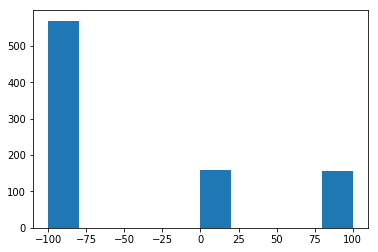

In [4]:
def nps_substitution(x):
    if x >= 9: 
        return 100
    elif x <= 6:
        return -100
    return 0
subbed_nps = nps.apply(nps_substitution)
plt.hist(subbed_nps)

In [5]:
subbed_nps.describe()
print('Got that, NPS-score is {}, NPS-variance is {}'.format(subbed_nps.mean(), subbed_nps.std()**2))

Got that, NPS-score is -46.55367231638418, NPS-variance is 6042.973643173045


In [6]:
# Double check on the variance (REMEMBER BESSEL CORRECTION!!!)
nps_score = subbed_nps.mean()
print(sum([((x - nps_score)**2 ) for x in subbed_nps]) / (subbed_nps.count() - 1))


6042.973643173018


## Hey, remember that fancy formula for NPS Variance??
 
$$  Var(NPS) =  (100 - NPS)^2 * \frac{promoters}{total} + (0 - NPS)^2 * \frac{passive}{total} + (-100 - NPS)^2 * \frac{detractors}{total} $$

What if we tried to compute that by hand... (Afterwards we'll try the third way)

In [7]:
bessel_denom = nps.count() - 1

promo_frac = promoters[promoters==1].count() / bessel_denom
passive_frac = passives[passives==1].count() / bessel_denom
detrac_frac = detractors[detractors==1].count() / bessel_denom

print('my proportions : {}, {}, {}'.format(promo_frac, passive_frac, detrac_frac))

part_a = ((100 - nps_score)**2) * promo_frac
part_b = ((0 - nps_score)**2) * passive_frac
part_c = ((-100 - nps_score)**2) * detrac_frac

print('Var(NPS), by the fancy formula : {}'.format(part_a + part_b + part_c))

my proportions : 0.17760180995475114, 0.17986425339366516, 0.6436651583710408
Var(NPS), by the fancy formula : 6042.973643173045


## Let's go by the other variance formula I have...

$$  Var(p - q) = Var(p) + Var(q) - 2*Cov(p,q) $$

But it's a little more complicated than that, p & q are proportions, I want percentages. So I need 

$$ Var(100 * p - 100 * q) = 100^2*Var(p) + 100^2*Var(q) - 2*(100*100)*Cov(p, q) $$

Remember:
    * Var(p) = p * (1-p)
    * Var(q) = q * (1-q)
    * Cov(p,q) = pq


In [8]:
var_p = promo_frac * (1 - promo_frac)
var_q = detrac_frac * (1 - detrac_frac)
covar = promo_frac * detrac_frac
coef = 100**2
print(var_p, var_q, covar, coef)

coef * (var_p + var_q + (2*covar))


0.1460594070555476 0.22936032227022377 0.11431609713150838 10000


6040.519235887881

In [9]:
covar = var_p + var_q